In [1]:
from SimPEG import *
import simpegDCIP as DC
from simpegem1d import Utils1D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


# DC Forward Modeling of Schlumber array

Here we test the accuracy of DC forward modeling using analytic solution.

## Step1: Generate mesh

In [2]:
cs = 25.
npad = 11
hx = [(cs,npad, -1.3),(cs,41),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,17),(cs,npad, 1.3)]
hz = [(cs,npad, -1.3),(cs,20)]

In [3]:
mesh = Mesh.TensorMesh([hx, hy, hz], 'CCN')

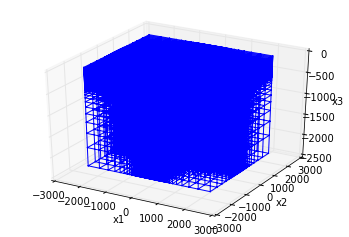

In [4]:
mesh.plotGrid()

## Step2: Generating model

In [5]:
sighalf = 1e-2
sigma = np.ones(mesh.nC)*sighalf

## Step3: Design survey: Schulumberger array

<img src="http://www.landrinstruments.com/_/rsrc/1271695892678/home/ultra-minires/additional-information-1/schlumberger-soundings/schlum%20array.JPG"> </img>

### $$ \rho_a = \frac{V}{I}\pi\frac{b(b+a)}{a}$$

#### Let $b=na$, then we rewrite above equation as:

### $$ \rho_a = \frac{V}{I}\pi na(n+1)$$

#### Since AB/2 can be a good measure for depth of investigation, we express 

### $$AB/2 = \frac{(2n+1)a}{2}$$

In [6]:
matplotlib.rcParams.update({'font.size': 14, 'text.usetex': True, 'font.family': 'arial'})

In [7]:
ntx = 16

In [8]:
xtemp_txP = np.arange(ntx)*(25.)-500.
xtemp_txN = -xtemp_txP
ytemp_tx = np.zeros(ntx)
xtemp_rxP = -50.
xtemp_rxN = 50.
ytemp_rx = 0.
abhalf = abs(xtemp_txP-xtemp_txN)*0.5
a = xtemp_rxN-xtemp_rxP
b = ((xtemp_txN-xtemp_txP)-a)*0.5

(-600, 600)

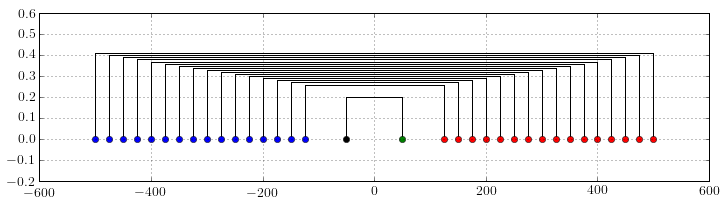

In [9]:
fig, ax = plt.subplots(1,1, figsize = (12,3))
for i in range(ntx):
    ax.plot(np.r_[xtemp_txP[i], xtemp_txP[i]], np.r_[0., 0.4-0.01*(i-1)], 'k-', lw = 1)
    ax.plot(np.r_[xtemp_txN[i], xtemp_txN[i]], np.r_[0., 0.4-0.01*(i-1)], 'k-', lw = 1)
    ax.plot(xtemp_txP[i], ytemp_tx[i], 'bo')
    ax.plot(xtemp_txN[i], ytemp_tx[i], 'ro')
    ax.plot(np.r_[xtemp_txP[i], xtemp_txN[i]], np.r_[0.4-0.01*(i-1), 0.4-0.01*(i-1)], 'k-', lw = 1)    

ax.plot(np.r_[xtemp_rxP, xtemp_rxP], np.r_[0., 0.2], 'k-', lw = 1)
ax.plot(np.r_[xtemp_rxN, xtemp_rxN], np.r_[0., 0.2], 'k-', lw = 1)
ax.plot(xtemp_rxP, ytemp_rx, 'ko')
ax.plot(xtemp_rxN, ytemp_rx, 'go')
ax.plot(np.r_[xtemp_rxP, xtemp_rxN], np.r_[0.2, 0.2], 'k-', lw = 1)    

ax.grid(True)    
ax.set_ylim(-0.2,0.6)
ax.set_xlim(-600,600)

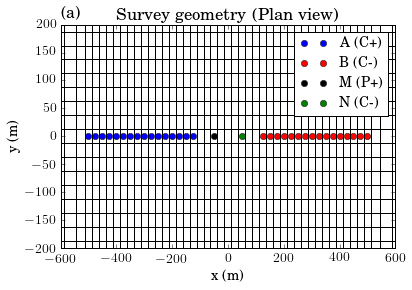

In [10]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
ax.plot(xtemp_txP, ytemp_tx, 'bo')
ax.plot(xtemp_txN, ytemp_tx, 'ro')
ax.plot(xtemp_rxP, ytemp_rx, 'ko')
ax.plot(xtemp_rxN, ytemp_rx, 'go')
ax.legend(('A (C+)', 'B (C-)', 'M (P+)', 'N (C-)'), fontsize = 14)
mesh.plotSlice(sigma, grid=True, ax = ax, pcolorOpts={'cmap':'binary'})
ax.set_xlim(-600, 600)
ax.set_ylim(-200, 200)
ax.set_title('Survey geometry (Plan view)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.text(-600, 210, '(a)', fontsize = 16)
# fig.savefig('DCsurvey.png', dpi = 200)

In [11]:
txlist = []
rx = DC.RxDipole(np.r_[xtemp_rxP, ytemp_rx, -12.5], np.r_[xtemp_rxN, ytemp_rx, -12.5])
for i in range(ntx):    
    tx = DC.SrcDipole([rx], [xtemp_txP[i], ytemp_tx[i], -12.5],[xtemp_txN[i], ytemp_tx[i], -12.5])
    txlist.append(tx)
survey = DC.SurveyDC(txlist)
problem = DC.ProblemDC_CC(mesh)
problem.pair(survey)
try:
    from pymatsolver import MumpsSolver
    problem.Solver = MumpsSolver
except Exception, e:
    problem.Solver = SolverLU    

## Step4: Run DC forward modeling

In [14]:
%%time
data = survey.dpred(sigma)

CPU times: user 5.26 s, sys: 554 ms, total: 5.81 s
Wall time: 4.06 s


$$ \rho_a = \frac{V}{I}\pi\frac{b(b+a)}{a}$$

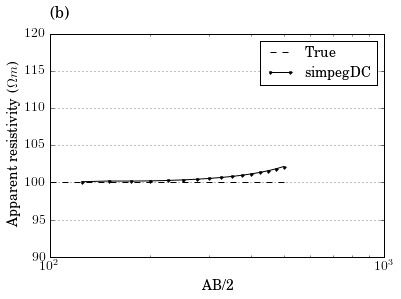

In [15]:
appres = data*np.pi*b*(b+a)/a


fig, ax = plt.subplots(1,1, figsize = (6, 4))
ax.semilogx(np.r_[100., 500.], np.r_[100., 100.], 'k--')
ax.semilogx(abhalf, appres, 'k.-')
ax.set_ylim(90., 120.)
ax.set_xscale('log')
ax.set_xlabel('AB/2')
ax.set_ylabel('Apparent resistivity ($\Omega m$)')
ax.grid(True)
ax.text(100, 122, '(b)', fontsize = 16)
ax.legend(('True', 'simpegDC'), loc = 1, fontsize = 14)
# fig.savefig('comp_dc.png')